# Uncertainty estimation for non-linear regression

In [47]:
import numpy as np
import lmfit
import scipy

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

Some plot configurations:

In [48]:
plt.rc('font',   size=16)          # controls default text sizes
plt.rc('axes',   titlesize=18)     # fontsize of the axes title
plt.rc('axes',   labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick',  labelsize=18)     # fontsize of the tick labels
plt.rc('ytick',  labelsize=18)     # fontsize of the tick labels
plt.rc('legend', fontsize=18)      # legend fontsize
plt.rc('figure', titlesize=18)     # fontsize of the figure title

## The model to fit

The model we want to fit is a Gaussian superimposed on a slope:

$$ f(x) = a + b\ x + A \ e^{-\frac{\displaystyle(x-\mu)^2}{\displaystyle 2\sigma^2}} $$

which has 5 fit parameters: $a$, $b$, $A$, $\mu$, and $\sigma$.

In [49]:
def f(x, a, b, A, mu, sigma):
    """
    A gaussian superimposed on a slope
    """
    return a + b * x + A * np.exp(-0.5 * (x - mu)**2 / sigma**2)

We will also be using the Jacobian:

$$ J(\mathbf{\theta}) = \left[\frac{\displaystyle\partial f(x_i, \mathbf{\theta})}{\displaystyle\partial \theta_j} \right]^{N\times K}$$

where $N$ is the number of observations, and $K$ is the number of fit parameters.

In [50]:
def jacobian(x, a, b, A, mu, sigma):
    """
    Jacobian of the model function f() con
    
    Input:
        x:
        a:
        b:
        A: 
        mu:
        sigma: 
    """

    Nparam = 5                                                             # 5 fit parameters
    J = np.zeros((len(x), Nparam))
    J[:,0] = np.ones_like(x)                                               # 1st col: derivative w.r.t. 'a'
    J[:,1] = x                                                             # 2nd col: derivative w.r.t. 'b'
    J[:,2] = np.exp(-0.5 * (x - mu)**2 / sigma**2)                         # 3rd col: derivative w.r.t. 'A'
    J[:,3] = A * (x-mu) / sigma**2 * np.exp(-0.5 * ((x-mu)/sigma)**2)      # 4th col: derivative w.r.t. 'mu'
    J[:,4] = A * (x-mu)**2 / sigma**3 * np.exp(-0.5 * ((x-mu)/sigma)**2)   # 5th col: derivative w.r.t. 'sigma'

    return J

## Creating an artificial noisy dataset

In [51]:
rng = np.random.default_rng(219)                                     # random number generator
    
a = 1.0                                                               # intercept of the linear background term
b = 0.1                                                               # slope of the linear background
A = 1.5                                                               # amplitude of the gaussian
mu = 5.0                                                              # center of the gaussian
sigma = 1                                                             # standard deviation of the gaussian

N = 50                                                                # Number of observations
x = np.linspace(0, 10, N)                                             # N evenly spread points between 0 and 10
y = f(x, a, b, A, mu, sigma) + rng.normal(0.0, 0.2, N)

Also save the dataset to a csv text file:

In [52]:
np.savetxt("dataset.csv", np.transpose([x,y]), delimiter=",")

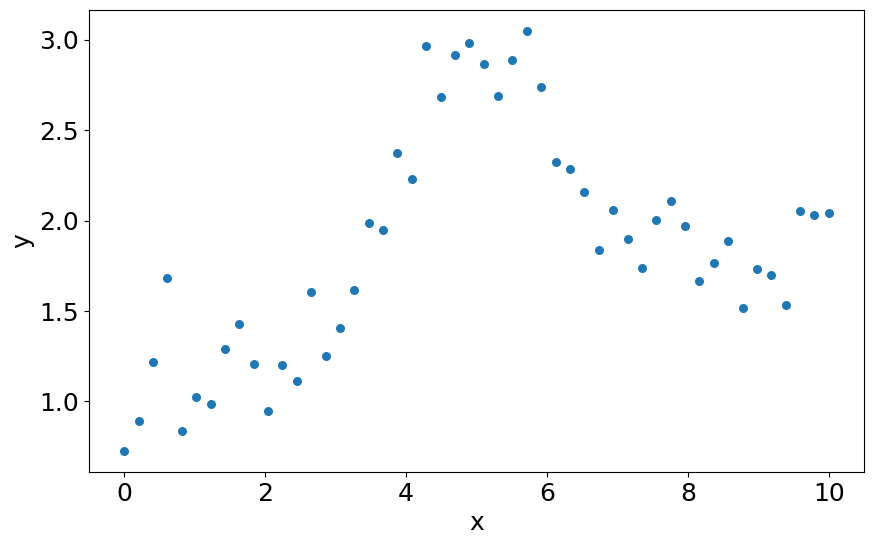

In [53]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
plt.scatter(x, y, marker='o', s=30)
ax.set_xlabel('x')
ax.set_ylabel('y') 
plt.show()

## Fitting the model to the data using lmfit

In [64]:
myModel = lmfit.Model(f)

myModel.set_param_hint('a', value=1.0)
myModel.set_param_hint('b', value=1.0)
myModel.set_param_hint('A', value=1.0)
myModel.set_param_hint('mu', value=5.0)
myModel.set_param_hint('sigma', value=1.0, min=0.0)

In [65]:
myFit = myModel.fit(y, x=x)

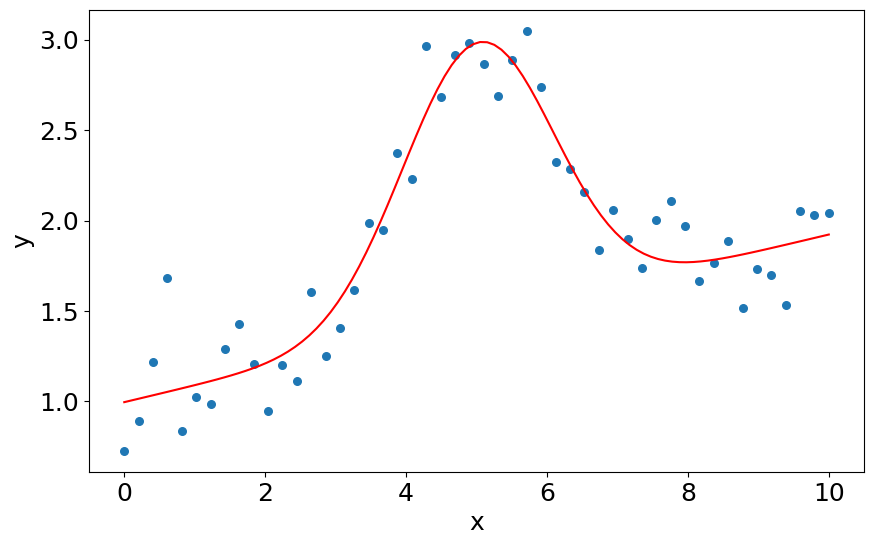

In [66]:
xx = np.linspace(0.0, 10, 100)
yy = myModel.eval(x=xx, params=myFit.params)

fig, ax = plt.subplots(1,1, figsize=(10,6))
plt.scatter(x, y, marker='o', s=30)
plt.plot(xx, yy, c='r')
ax.set_xlabel('x')
ax.set_ylabel('y') 
plt.show()

In [67]:
a_best = myFit.best_values['a']
b_best = myFit.best_values['b']
A_best = myFit.best_values['A']
mu_best = myFit.best_values['mu']
sigma_best = myFit.best_values['sigma']

Our best fit parameters are thus:

In [68]:
standard_errors = np.sqrt(myFit.covar.diagonal())
print("Best fit parameters: ", a_best, b_best, A_best, mu_best, sigma_best)
print("Corresponding standard errors: ", standard_errors)

Best fit parameters:  0.9954097556387486 0.0926938610782855 1.5239579226072766 5.022309601635896 1.0723037716367685
Corresponding standard errors:  [0.06832032 0.01048832 0.08887724 0.0712164  0.08062398]


## Manually computing the error bars

Within the maximum likelihood framework, the covariance matrix ${\rm Cov}[\theta]$ of the fit parameters is usually computed using the inverse of the Fisher information $I(\theta)$:

$$ {\rm Cov}[\hat{\theta}] = I^{-1}(\hat{\theta}).  $$
with
$$ I(\theta) = - \left[ \frac{\displaystyle \partial^2 l(\theta)}{\displaystyle \partial\theta_i \partial\theta_j}\right]_{ij} $$

where $l(\theta)$ is the log-likelihood. Here we abbreviated $\theta = \{\theta_1, \theta_2, \theta_3, \theta_4, \theta_5\} = \{a, b, A, \mu, \sigma\}$

In the case of Gaussian noise the log-likelihood becomes:

$$ \ln L(\theta) = -\frac{N}{2} \ln\sigma^2 - \frac{N}{2} \ln(2\pi) - \frac{1}{2\sigma^2} \sum\limits_{n=1}^N [y_n - f(x_n, \theta)]^2 \equiv -\frac{N}{2} \ln\sigma^2 - \frac{N}{2} \ln(2\pi) - \frac{S(\theta)}{2\sigma^2} $$
where we abbreviated
$$ S(\theta) = \sum_{n=1}^N [y_n - f(x_n, \theta)]^2. $$

The 2nd partial derivatives of the log-likelihood imply 2nd derivatives of $S(\theta)$ and thus 2nd derivates of the model function:

$$ \frac{\displaystyle\partial^2 S(\theta)}{\displaystyle \partial\theta_i\partial\theta_j} = 2 \sum\limits_{n=1}^N \left[ \frac{\partial f(x_n, \theta)}{\partial\theta_i} \cdot \frac{\partial f(x_n, \theta)}{\partial\theta_j} - (y_n - f(x_n, \theta)) \frac{\partial^2 f(x_n, \theta)}{\partial\theta_i\partial\theta_j}\right] $$

lmfit computes these 2nd derivatives using the [numdifftools](https://numdifftools.readthedocs.io/en/stable/intro/index.html) package which uses automatic differentation.
Some other packages opt to not use the observed Fisher information matrix, but the expected information matrix $E[I(\theta)]$. As our model $f(x,\theta)$ is assumed to be an unbiased model of the data, the 2nd term in the expression above is on average zero. The expected Fisher information matrix can then be computed using only the Jacobian:  

$$ E\left[  \frac{\displaystyle\partial^2 S(\theta)}{\displaystyle \partial\theta_i\partial\theta_j} \right] = 2\  J' \cdot J $$
and thus
$$ Cov[\hat{\theta}] = s^2 \ (\hat{J}' \cdot \hat{J})^{-1}.   $$
where
$$ s^2 = \frac{\displaystyle S(\hat{\theta})}{\displaystyle N-K} $$
is an unbiased estimate of the variance of the noise.

The practical implementation is:

In [58]:
def chisquare(x, y, a, b, A, mu, sigma):
    model = f(x, a, b, A, mu, sigma)
    return np.sum(np.square(y - model)) 

In [59]:
K = 5                                                                            # K = number of fit parameters
chisquare_best = chisquare(x, y, a_best, b_best, A_best, mu_best, sigma_best)
variance_residuals = chisquare_best / (N-K)                                      # N = number of observations

In [60]:
J = jacobian(x, a_best, b_best, A_best, mu_best, sigma_best)
cov_matrix = variance_residuals * np.linalg.inv(J.T @ J)   

In [61]:
sigmas = np.sqrt(cov_matrix.diagonal())
print("Manually computed standard errors: ", sigmas)

Manually computed standard errors:  [0.06832113 0.01048836 0.08887673 0.07121782 0.08062534]


---